In [1]:
import torch
from typing import List
import os
import sys

from os.path import join

sys.path.insert(0, os.getcwd())

from stable_diffusion2.model.clip_text_embedder import CLIPTextEmbedder
from stable_diffusion2 import StableDiffusion
from stable_diffusion2.utils.utils import (
    check_device,
    get_memory_status,
    to_pil,
    save_image_grid,
    show_image_grid,
)

EMBEDDED_PROMPTS_DIR = os.path.abspath("./input/embedded_prompts/")
NULL_PROMPT = ""
PROMPTS = "An old photo of a computer scientist"
NUM_IMAGES = 16
SEED = 2982
NOISE_MULTIPLIER = 0.05

os.makedirs(EMBEDDED_PROMPTS_DIR, exist_ok=True)
# DEVICE = input("Set device: 'cuda:i' or 'cpu'")
DEVICE = "cuda:0"
DEVICE = check_device(DEVICE)

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [2]:
def embed_and_save_prompts(prompts: list, null_prompt=NULL_PROMPT):
    null_prompt = null_prompt
    prompts = prompts

    clip_text_embedder = CLIPTextEmbedder(device=check_device())
    clip_text_embedder.load_submodels()

    null_cond = clip_text_embedder(null_prompt)
    torch.save(null_cond, join(EMBEDDED_PROMPTS_DIR, "null_cond.pt"))
    print(
        "Null prompt embedding saved at: ",
        f"{join(EMBEDDED_PROMPTS_DIR, 'null_cond.pt')}",
    )

    embedded_prompts = clip_text_embedder(prompts)
    torch.save(embedded_prompts, join(
        EMBEDDED_PROMPTS_DIR, "embedded_prompts.pt"))

    print(
        "Prompts embeddings saved at: ",
        f"{join(EMBEDDED_PROMPTS_DIR, 'embedded_prompts.pt')}",
    )

    get_memory_status()
    clip_text_embedder.to("cpu")
    del clip_text_embedder
    torch.cuda.empty_cache()
    get_memory_status()

    return embedded_prompts, null_cond

In [3]:
embedded_prompts, null_prompt = embed_and_save_prompts(PROMPTS)

INFO: `device` is None. Falling back to current device.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Null prompt embedding saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\embedded_prompts\null_cond.pt
Prompts embeddings saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\embedded_prompts\embedded_prompts.pt
Total: 12287 MiB
Free: 10376 MiB
Used: 1911 MiB
Total: 12287 MiB
Free: 10522 MiB
Used: 1765 MiB


In [4]:
# check the shape of the embedded prompts
embedding_shape = tuple(embedded_prompts.shape)
embedding_shape

(1, 77, 768)

In [5]:
# check mean and std to use the same for the noise generation
# one idea is to use one distribution per position (in the 77 positions)
# in this case we would check the mean and std along dimension 2
# embedded_prompts.mean(dim=2), embedded_prompts.std(dim=2)
embedding_mean, embedding_std = embedded_prompts.mean(), embedded_prompts.std()
embedding_mean, embedding_std

(tensor(-0.1092, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0230, device='cuda:0', grad_fn=<StdBackward0>))

In [6]:
# generate noise and add to the embedded prompt
generator = torch.Generator(device=DEVICE).manual_seed(SEED)
noise = torch.normal(
    mean=embedding_mean.item(),
    std=embedding_std.item(),
    size=embedding_shape,
    device=DEVICE,
    generator=generator,
)
noise.shape

torch.Size([1, 77, 768])

In [7]:
embedding_e = embedded_prompts + 0.1 * noise

In [8]:
get_memory_status()

Total: 12287 MiB
Free: 10522 MiB
Used: 1765 MiB


In [9]:
%%capture
sd = StableDiffusion(device=DEVICE)
sd.quick_initialize().load_autoencoder().load_decoder()
sd.model.load_unet()

In [10]:
get_memory_status()

Total: 12287 MiB
Free: 7032 MiB
Used: 5255 MiB


In [11]:
image = sd.generate_images_from_embeddings(
    seed=SEED, embedded_prompt=embedded_prompts, null_prompt=null_prompt
)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

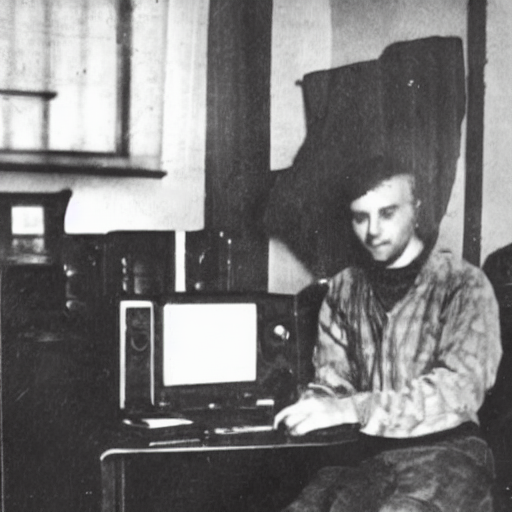

In [12]:
to_pil(image[0])

In [13]:
image_e = sd.generate_images_from_embeddings(
    seed=SEED, embedded_prompt=embedding_e, null_prompt=null_prompt
)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

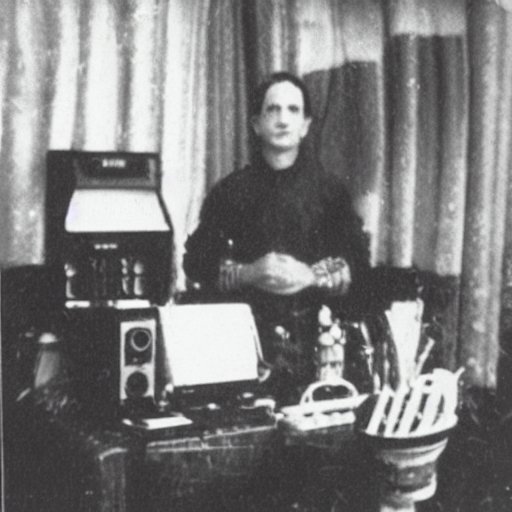

In [14]:
to_pil(image_e[0])

In [15]:
def generate_images_from_disturbed_embeddings(
    embedded_prompt,
    device=DEVICE,
    seed=SEED,
    num_images=NUM_IMAGES,
    noise_multiplier=NOISE_MULTIPLIER,
):
    generator = torch.Generator(device=device).manual_seed(seed)

    embedding_mean, embedding_std = embedded_prompt.mean(), embedded_prompt.std()
    embedding_shape = tuple(embedded_prompts.shape)

    noise = torch.normal(
        mean=embedding_mean.item(),
        std=embedding_std.item(),
        size=embedding_shape,
        device=device,
        generator=generator,
    )
    for i in range(0, num_images):
        embedding_e = embedded_prompt + (i * noise_multiplier) * noise
        image_e = sd.generate_images_from_embeddings(
            seed=seed, embedded_prompt=embedding_e, null_prompt=null_prompt
        )
        yield image_e[0]

In [16]:
image_generator = generate_images_from_disturbed_embeddings(embedded_prompts)

In [17]:
images = list(image_generator)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

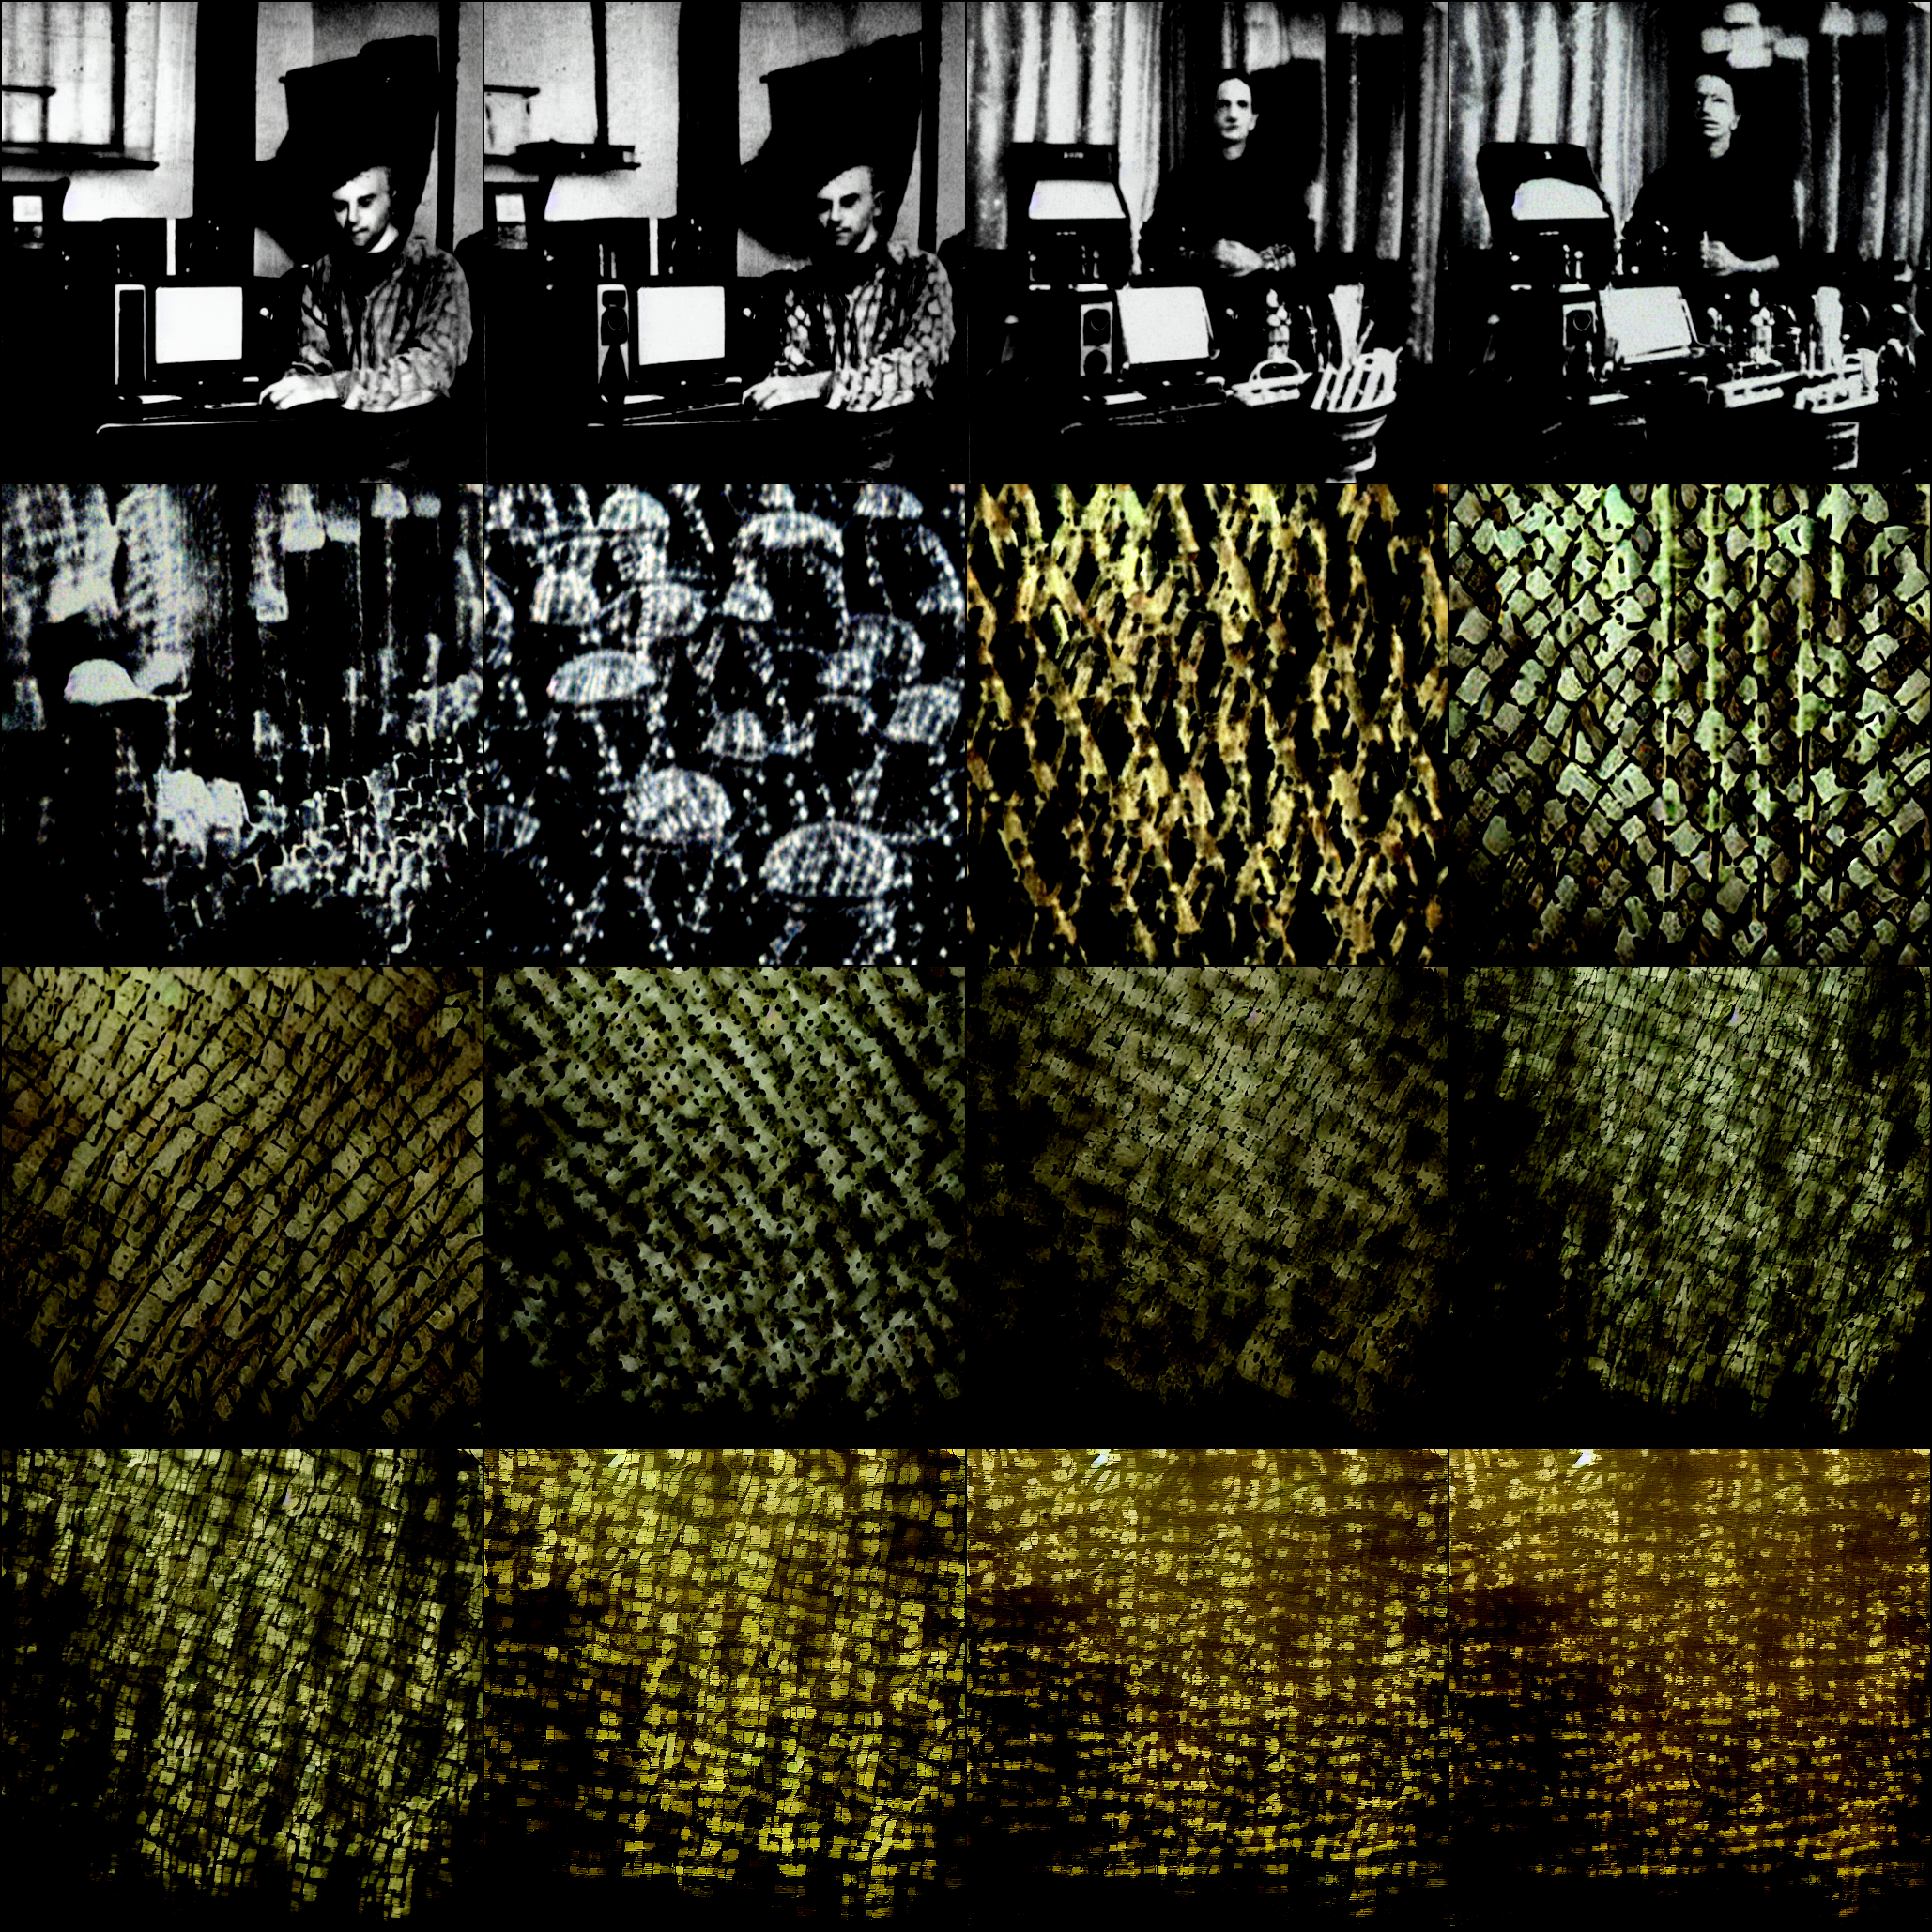

In [18]:
import math

show_image_grid(images, nrow=int(math.log(NUM_IMAGES, 2)))